# Data preprocessing

In [2]:
import os 
from glob import glob
data_list = glob('./Oxford-IIIT-Pet-Dataset/images/*')
label_prefix = os.path.abspath('./Oxford-IIIT-Pet-Dataset/annotations/trimaps')
label_list = []

for data in data_list:
    label = data.split('/')[-1].split('.')[0]+'.png'
    label_list.append( os.path.join(label_prefix, label))
    
print (label_list[0])
# label_list = glob('./Oxford-IIIT-Pet-Dataset/annotations/trimaps/*')

/home/kyungpyo/git/Prj_ImageSegmentation/notebook/Oxford-IIIT-Pet-Dataset/annotations/trimaps/wheaten_terrier_48.png


In [3]:
# Hyper Parameter 
batch_size = len(data_list)
data_height = 128
data_width = 128
channel_n = 3

In [4]:
from PIL import Image
import numpy as np

image = np.array(Image.open(label_list[0]))
Image.open(label_list[0]).show()
print ( image.shape )
print (len(data_list))

(333, 500)
7390


In [5]:
batch_image = np.zeros((batch_size, data_height, data_width, channel_n), dtype=np.uint8)
batch_label = np.zeros((batch_size, data_height, data_width), dtype=np.uint8)
batch_image_path = []
data_size = 0
for i, data in enumerate(data_list):
    np_data = np.array((Image.open(data).resize((data_height, data_width)).convert('RGB')), dtype=np.uint8)
    
    if not np_data.shape[-1] == channel_n:
        print (data)
        print (label_list[i])
        print ("data is not rgb:", np_data.shape)
        print ("skip this data...")
        continue
        
    batch_image[i] = np_data
    batch_label[i] = np.array((Image.open(label_list[i]).resize((data_height, data_width))), dtype=np.uint8)
    batch_image_path.append(data)
    data_size += 1
print ("data size is", data_size)
print ("batch_image: ", batch_image.shape)
print ("batch_label: ", batch_label.shape)

data size is 7390
batch_image:  (7390, 128, 128, 3)
batch_label:  (7390, 128, 128)


In [6]:
batch_image = batch_image[:data_size]
batch_label = batch_label[:data_size]
batch_image_path = batch_image_path[:data_size]
print ("data size is", data_size)
print ("batch_image: ", batch_image.shape)
print ("batch_label: ", batch_label.shape)

data size is 7390
batch_image:  (7390, 128, 128, 3)
batch_label:  (7390, 128, 128)


In [10]:
np.save( 'images.npy', batch_image )
np.save( 'labels.npy', batch_label )

# Image segmentation

Num GPUs Available:  1


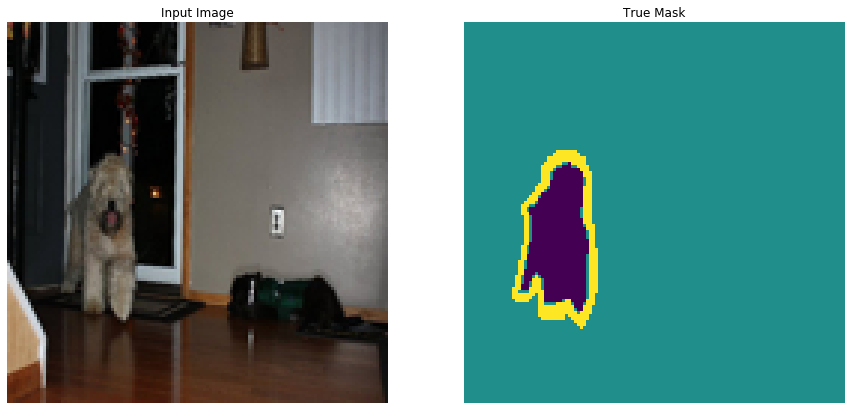

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 2GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
    print(e)
    
def normalize(input_image, input_mask):
  input_image = input_image.astype(np.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


images = np.load('images.npy')
labels = np.load('labels.npy').reshape( (7390, 128, 128, 1) )

norm_images, norm_labels = normalize(images, labels)

del images, labels
images = norm_images
labels = norm_labels

display([images[0], labels[0]])

In [12]:
import tensorflow as tf

# Hyper Parameter 
batch_size = 7384
data_height = 64
data_width = 64
channel_n = 3

TRAIN_LENGTH = batch_size
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (data_height, data_width))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (data_height, data_width))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


OUTPUT_CHANNELS = 3


base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [13]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 건너뛰기 연결을 업샘플링하고 설정하세요
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
if os.path.isdir('./unet'):
    model = tf.keras.models.load_model('./unet')
else:
    model = unet_model(OUTPUT_CHANNELS)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

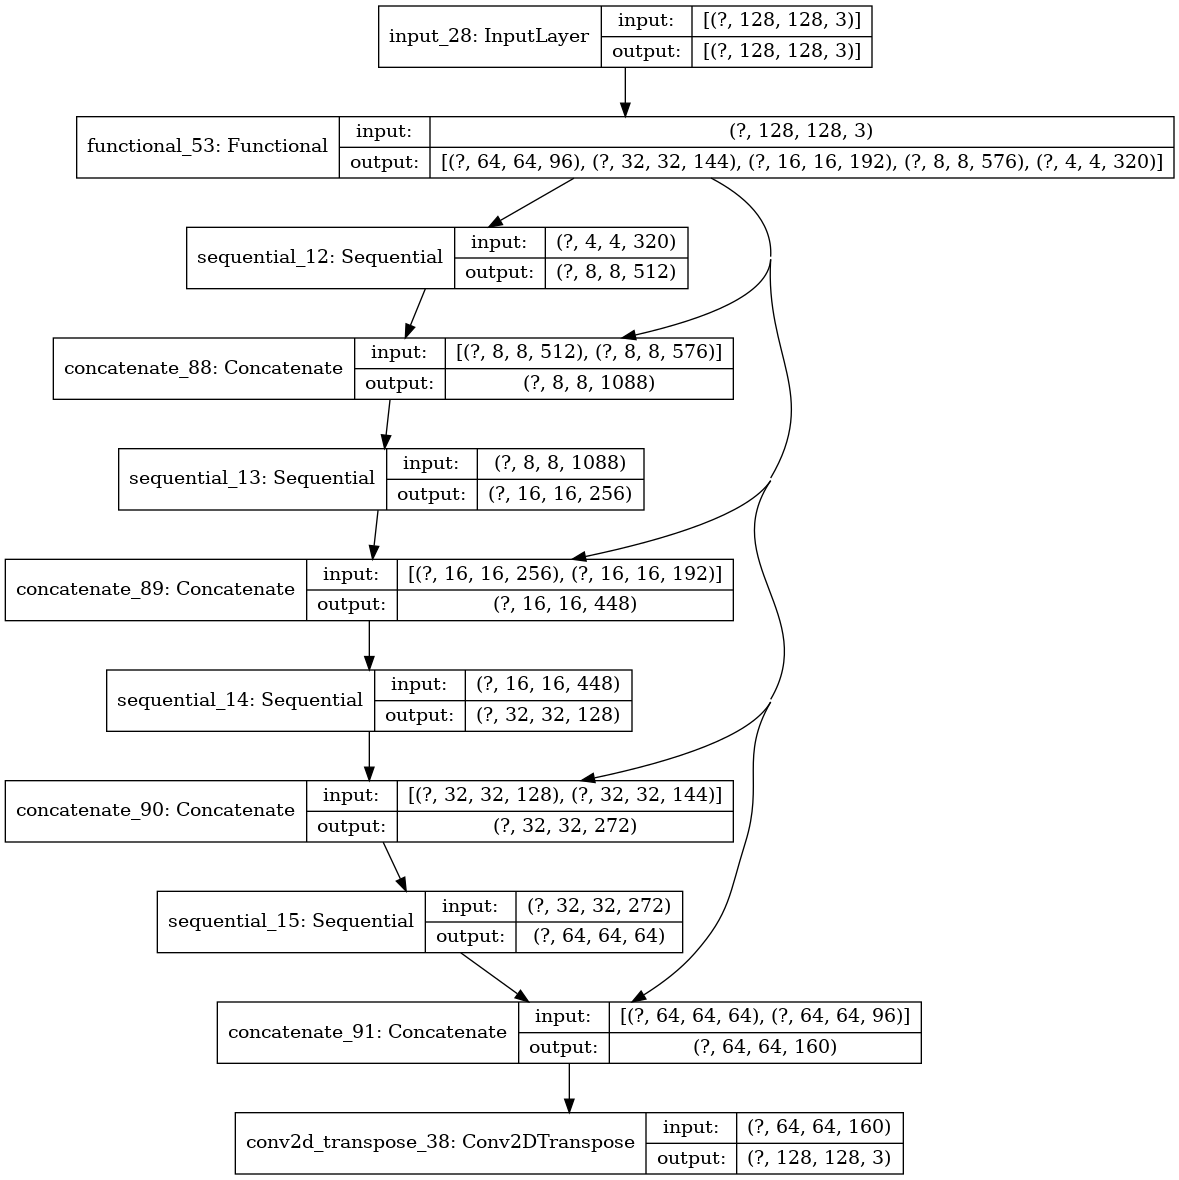

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.summary()

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
functional_53 (Functional)      [(None, 64, 64, 96), 1841984     input_28[0][0]                   
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8, 8, 512)    1476608     functional_53[0][4]              
__________________________________________________________________________________________________
concatenate_88 (Concatenate)    (None, 8, 8, 1088)   0           sequential_12[0][0]              
                                                                 functional_53[0][3]  

Time per image: 0.04902052879333496 sec 
20.39961674456609 FPS


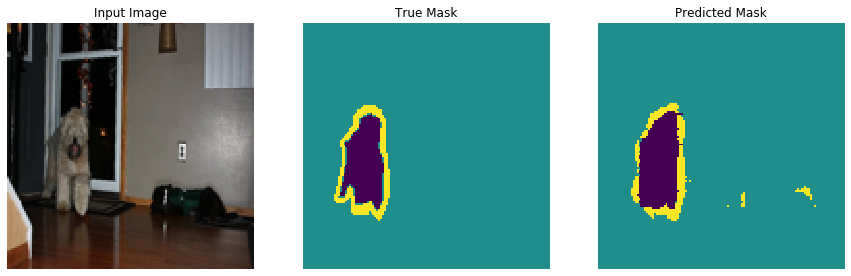

In [48]:
import time

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    input_image, input_mask = images[0], labels[0]
    
    start = time.time() 
    pred = model.predict(input_image[tf.newaxis, ...])
    end = time.time()
    print("Time per image: {} sec ".format((end-start))) 
    print( "{} FPS".format(1/(end-start)))
    display([input_image, input_mask, create_mask(pred)])

show_predictions()

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        show_predictions()
        print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

231/231 [==============================] - ETA: 0s - loss: 0.2833 - accuracy: 0.3062

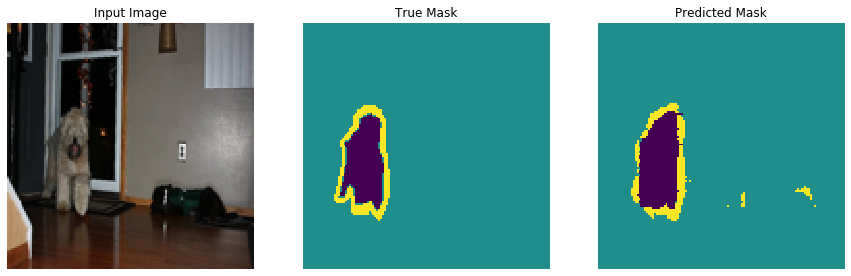


에포크 이후 예측 예시 1

231/231 [==============================] - 50s 218ms/step - loss: 0.2833 - accuracy: 0.3062


In [21]:
# Train
model_history = model.fit(images, labels, epochs=1, callbacks=[DisplayCallback()])

In [49]:
# model.save('unet')